In [195]:
"""
Alexandre
2024/10/18
"""

# Change the structure of the encoding layer

'\nAlexandre\n2024/10/18\n'

# **More tests**

## Initialisation part

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import nest
import os

In [197]:
cwd = os.getcwd()
print(cwd)

results_fodler_name = "C_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## network generation

In [198]:
# set general parameters
seed = 1
dt = 0.1
num_threads = 16

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# general parameters
gamma = 0.25 # relative number of inhibitory

# encoding layer parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA]

# main network parameters
NE = 1000 # number of excitatory neurons (10.000 in [1])
CE = 200 # indegree from excitatory neurons

# synapse parameters
w = 0.1 # excitatory synaptic weight (mV)
g = 5. # relative inhibitory to excitatory synaptic weight
d = 1.5 # synaptic transmission delay (ms)


Oct 21 13:02:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [199]:
# create the encoding layer 1
enc_layer_1 = nest.Create(
    model='iaf_psc_delta', 
    n=nEnc, 
    params={'I_e': J_bias}
)

# create the encoding layer 2
enc_layer_2 = nest.Create(
    model='iaf_psc_delta', 
    n=nEnc, 
    params={'I_e': J_bias}
)

# record the activity of the encoding layer 1
enc_spks_1 = nest.Create('spike_recorder')
nest.Connect(enc_layer_1, enc_spks_1)

# record the activity of the encoding layer 2
enc_spks_2 = nest.Create('spike_recorder')
nest.Connect(enc_layer_2, enc_spks_2)

# sparse connect the first layer to the second one
nest.Connect(enc_layer_1, enc_layer_2, conn_spec={"rule":"pairwise_bernoulli","p":0.5})

##### MAIN NETWORK #####
# population parameters
NI = int(gamma * NE) # number of inhibitory neurons
CI = int(gamma * CE) # indegree from inhibitory neurons

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
main_spks = nest.Create('spike_recorder')

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, main_spks)

# connect the encoding layer to both neuronal population
nest.Connect(enc_layer_2, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer_2, neurons_i, conn_exc, syn_exc)

## generate input and connect it to the network

In [200]:
# import librairies input stimulus generator
from utils.inputs import generate_piecewise_constant_signal

In [201]:
# encoding layer parameters
nEnc = 500 # number of neurons in the encoding layer

# stimulus parameters
step_duration = 20. # [ms]
scale = 1000. # input scaling factor [Hz]
num_steps = 100 # number of unique input values

In [202]:
# encoding layer 1 reparametrisation
tuning = 250. * np.random.randn(nEnc) + 1000. # 
thresholds_1 = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
Vm0_1 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

# encoding layer 1 reparametrisation
thresholds_2 = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
Vm0_2 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

# generation of the stimulus
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
    seed=seed, 
    num_steps=num_steps,
    step_duration=step_duration, 
    resolution=dt, 
    scale=scale
    )

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create(
    model='inhomogeneous_poisson_generator', 
    n=1
)

stim_pgen.set(
    {
        'rate_times': inp_times, 
        'rate_values': inp_amplitudes
    }
)

step_generator = nest.Create(
    model='step_current_generator', 
    n=nEnc
)
amplitudes = np.zeros((nEnc, len(inp_amplitudes)))

for n in range(nEnc): # for each neuron in the encoding layer
    
    # transform the input as function of the tuning of each neuron
    amplitudes[n, :] = inp_amplitudes * tuning[n] / 1000
    
    # change parameters of each neuron in the input layer
    enc_layer_1[n].set(
        {
            'V_m': Vm0_1[n], # set the membrane potential initialisation
            'V_th': thresholds_1[n] # set the excitation threshold
        }
    )

    # change parameters of each neuron in the input layer
    enc_layer_2[n].set(
        {
            'V_m': Vm0_2[n], # set the membrane potential initialisation
            'V_th': thresholds_2[n] # set the excitation threshold
        }
    )

    # change caracteristics of the input generator
    step_generator[n].set(
        {
            'amplitude_times': inp_times, # set the time
            'amplitude_values': amplitudes[n] # set the amplitude
        }
    )

    # connect the input generator to the encoding layer neuron one-by-one
    nest.Connect(
        step_generator[n],
        enc_layer_1[n]
    )

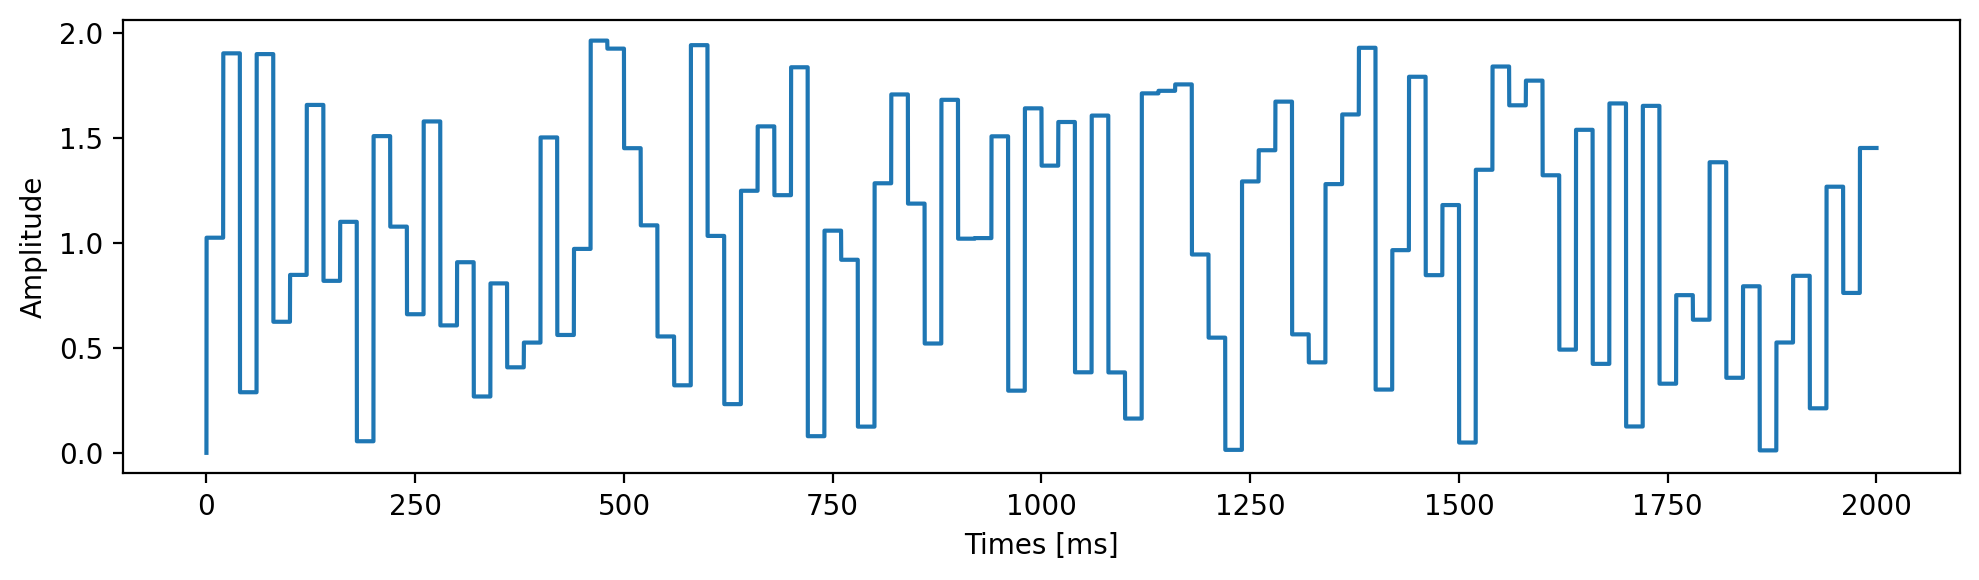

In [203]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,3),
    dpi=200
)

ax.plot(
    times,
    sig
)

ax.set_xlabel("Times [ms]")
ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

## run the simulation

In [204]:
# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)


Oct 21 13:02:38 NodeManager::prepare_nodes [Info]: 
    Preparing 10314 nodes for simulation.

Oct 21 13:02:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10314
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 13:02:42 SimulationManager::run [Info]: 
    Simulation finished.


## extract results

In [205]:
# extract the simulation results
from utils.extractors import filter_spikes_parallel

filter_tau = 20. # [ms]

In [206]:
enc_activity_1 = enc_spks_1.events
enc_states_1 = filter_spikes_parallel(
    enc_activity_1['times'], enc_activity_1['senders'], # use the timing and the origin of each spike of the encoding layer
    nEnc, # total number of neuron in the encoding layer
    t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
    tau=filter_tau, 
    n_processes=num_threads
)

enc_activity_2 = enc_spks_2.events
enc_states_2 = filter_spikes_parallel(
    enc_activity_2['times'], enc_activity_2['senders'], # use the timing and the origin of each spike of the encoding layer
    nEnc, # total number of neuron in the encoding layer
    t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
    tau=filter_tau, 
    n_processes=num_threads
)

main_activity = main_spks.events
main_states = filter_spikes_parallel(
    main_activity['times'], main_activity['senders'], 
    NE, 
    t_start=0., t_stop=sim_time, dt=dt, 
    tau=filter_tau, 
    n_processes=num_threads
)

Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:18<00:00, 52.96it/s]


## decoding

In [207]:
from sklearn.linear_model import LinearRegression

In [208]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [209]:
enc_estimate_1, enc_capacity_1, enc_error_1 = compute_capacity(enc_states_1, sig[1:])
enc_estimate_2, enc_capacity_2, enc_error_2 = compute_capacity(enc_states_2, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

print(f"Encoding Layer 1: \n\t- Capacity={enc_capacity_1}, MSE={enc_error_1}")
print(f"Encoding Layer 2: \n\t- Capacity={enc_capacity_2}, MSE={enc_error_2}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer 1: 
	- Capacity=0.52932012265141, MSE=0.15530122470756852
Encoding Layer 2: 
	- Capacity=0.4811658406069767, MSE=0.17139685724156642
Main Circuit: 
	- Capacity=0.5182149034519881, MSE=0.16020529892384297


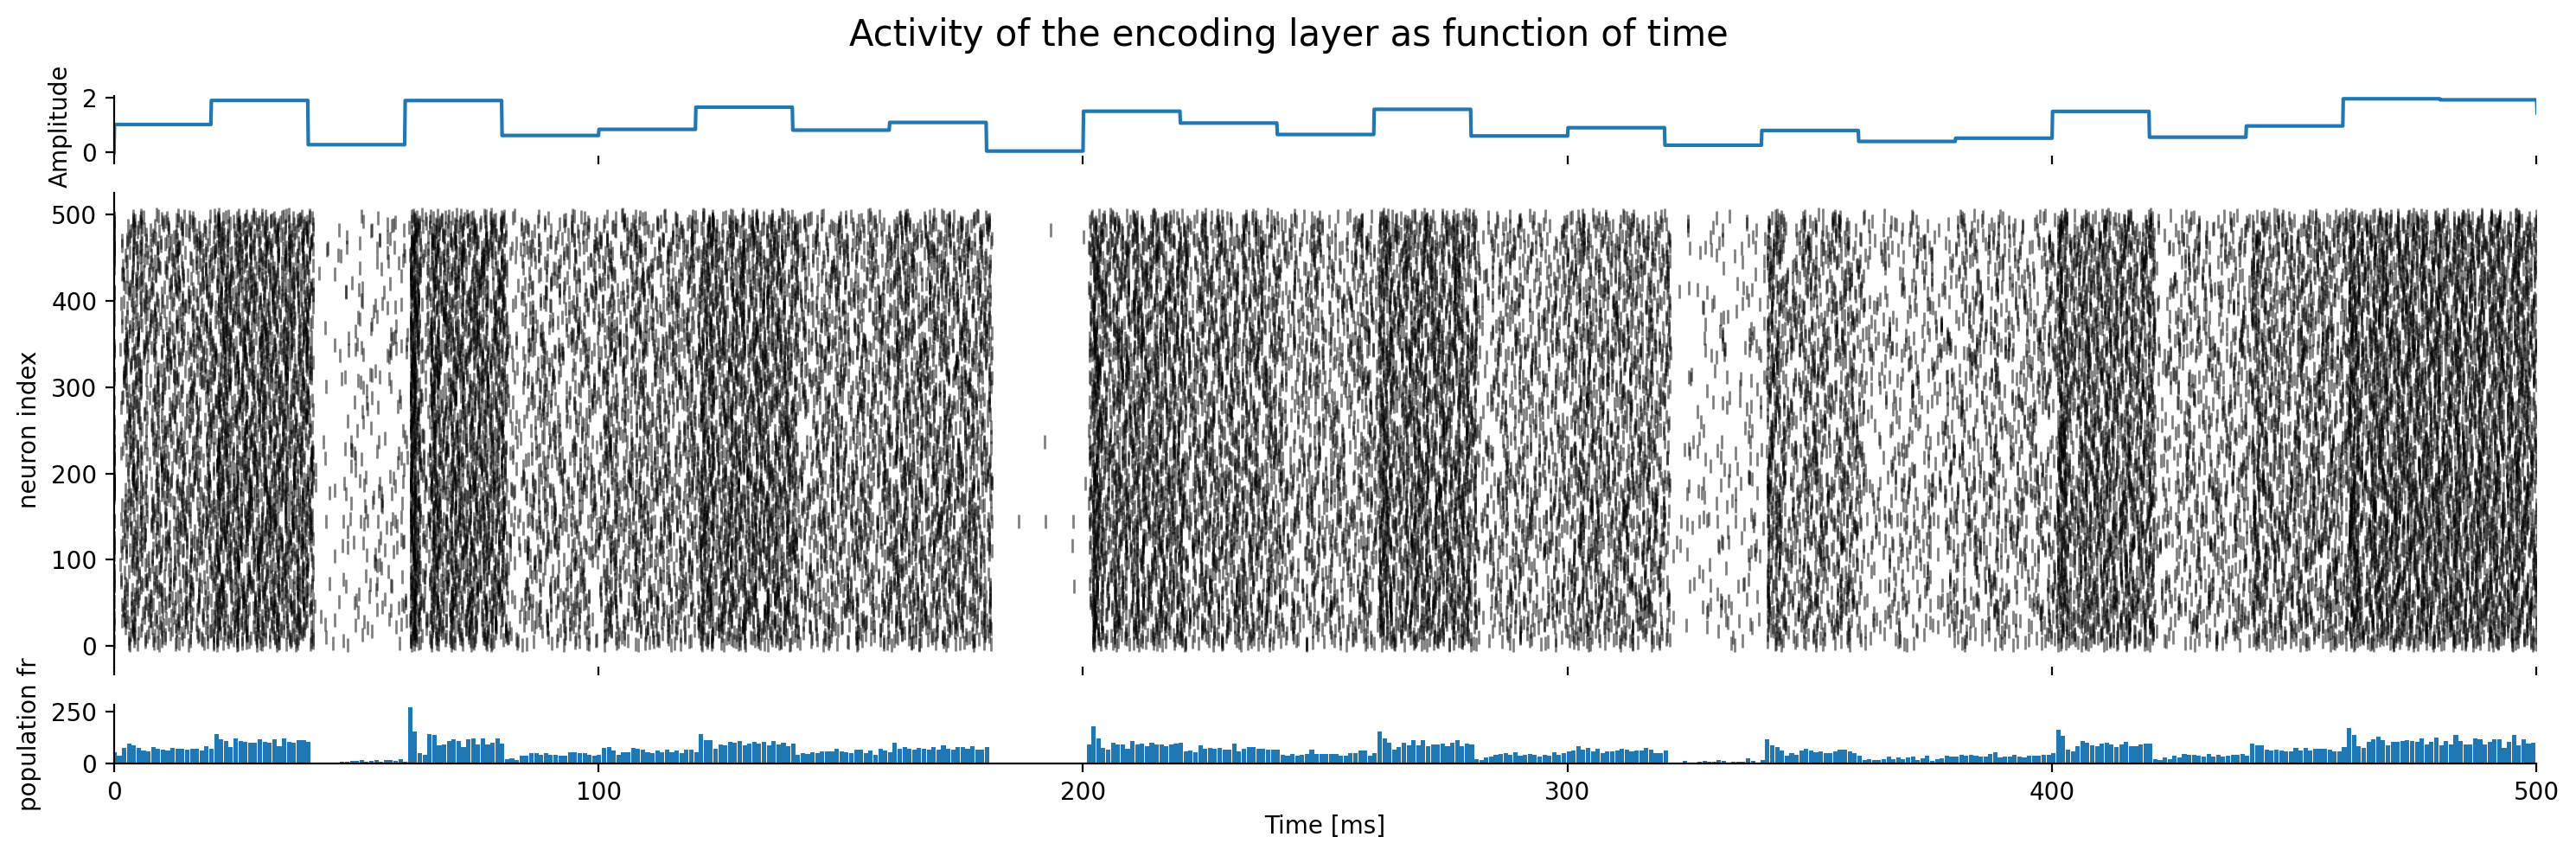

In [210]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks_1.events["times"],
    enc_spks_1.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks_1.events["times"],
    bins=np.linspace(
        enc_spks_1.events["times"].min(), 
        enc_spks_1.events["times"].max(), 
        int(enc_spks_1.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer_1.pdf"), dpi=200)
plt.show()

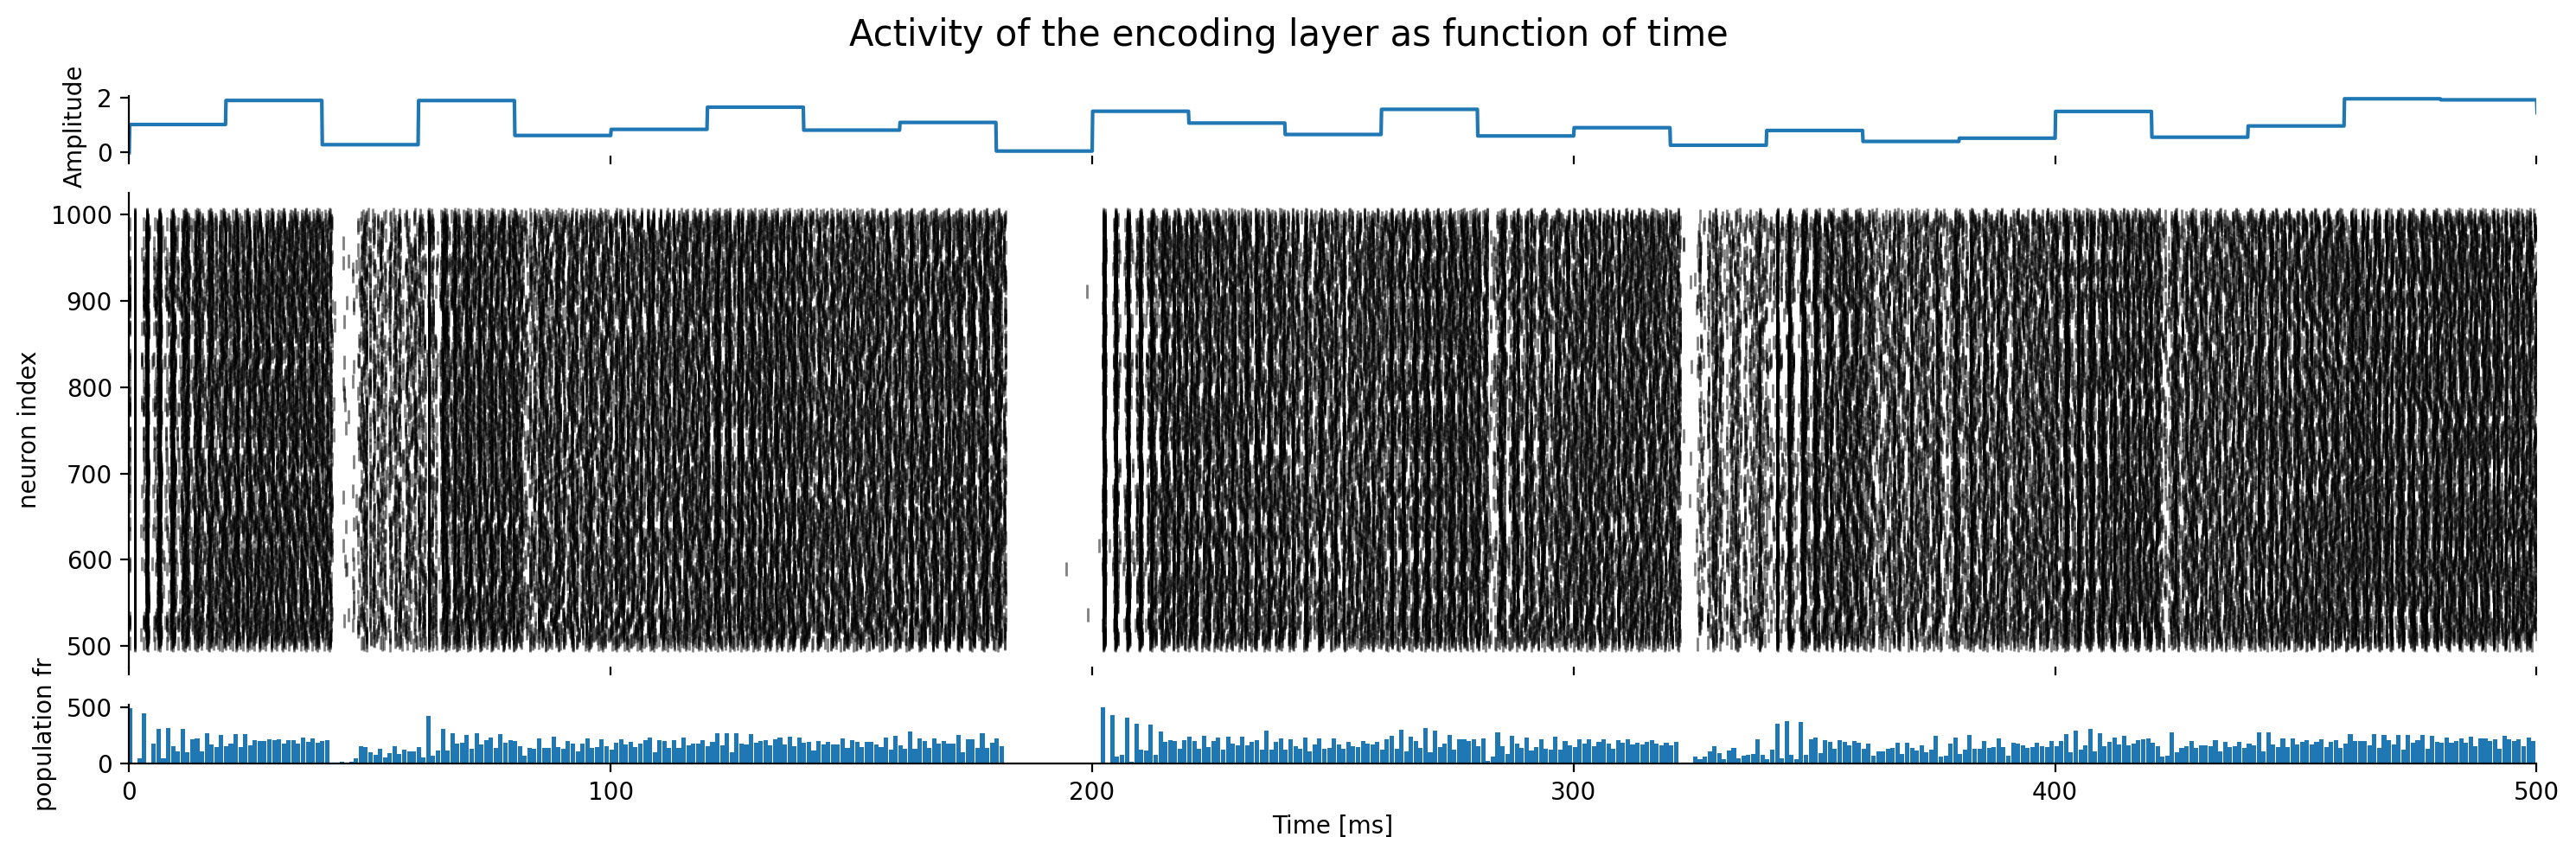

In [211]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks_2.events["times"],
    enc_spks_2.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks_2.events["times"],
    bins=np.linspace(
        enc_spks_2.events["times"].min(), 
        enc_spks_2.events["times"].max(), 
        int(enc_spks_2.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer_2.pdf"), dpi=200)
plt.show()

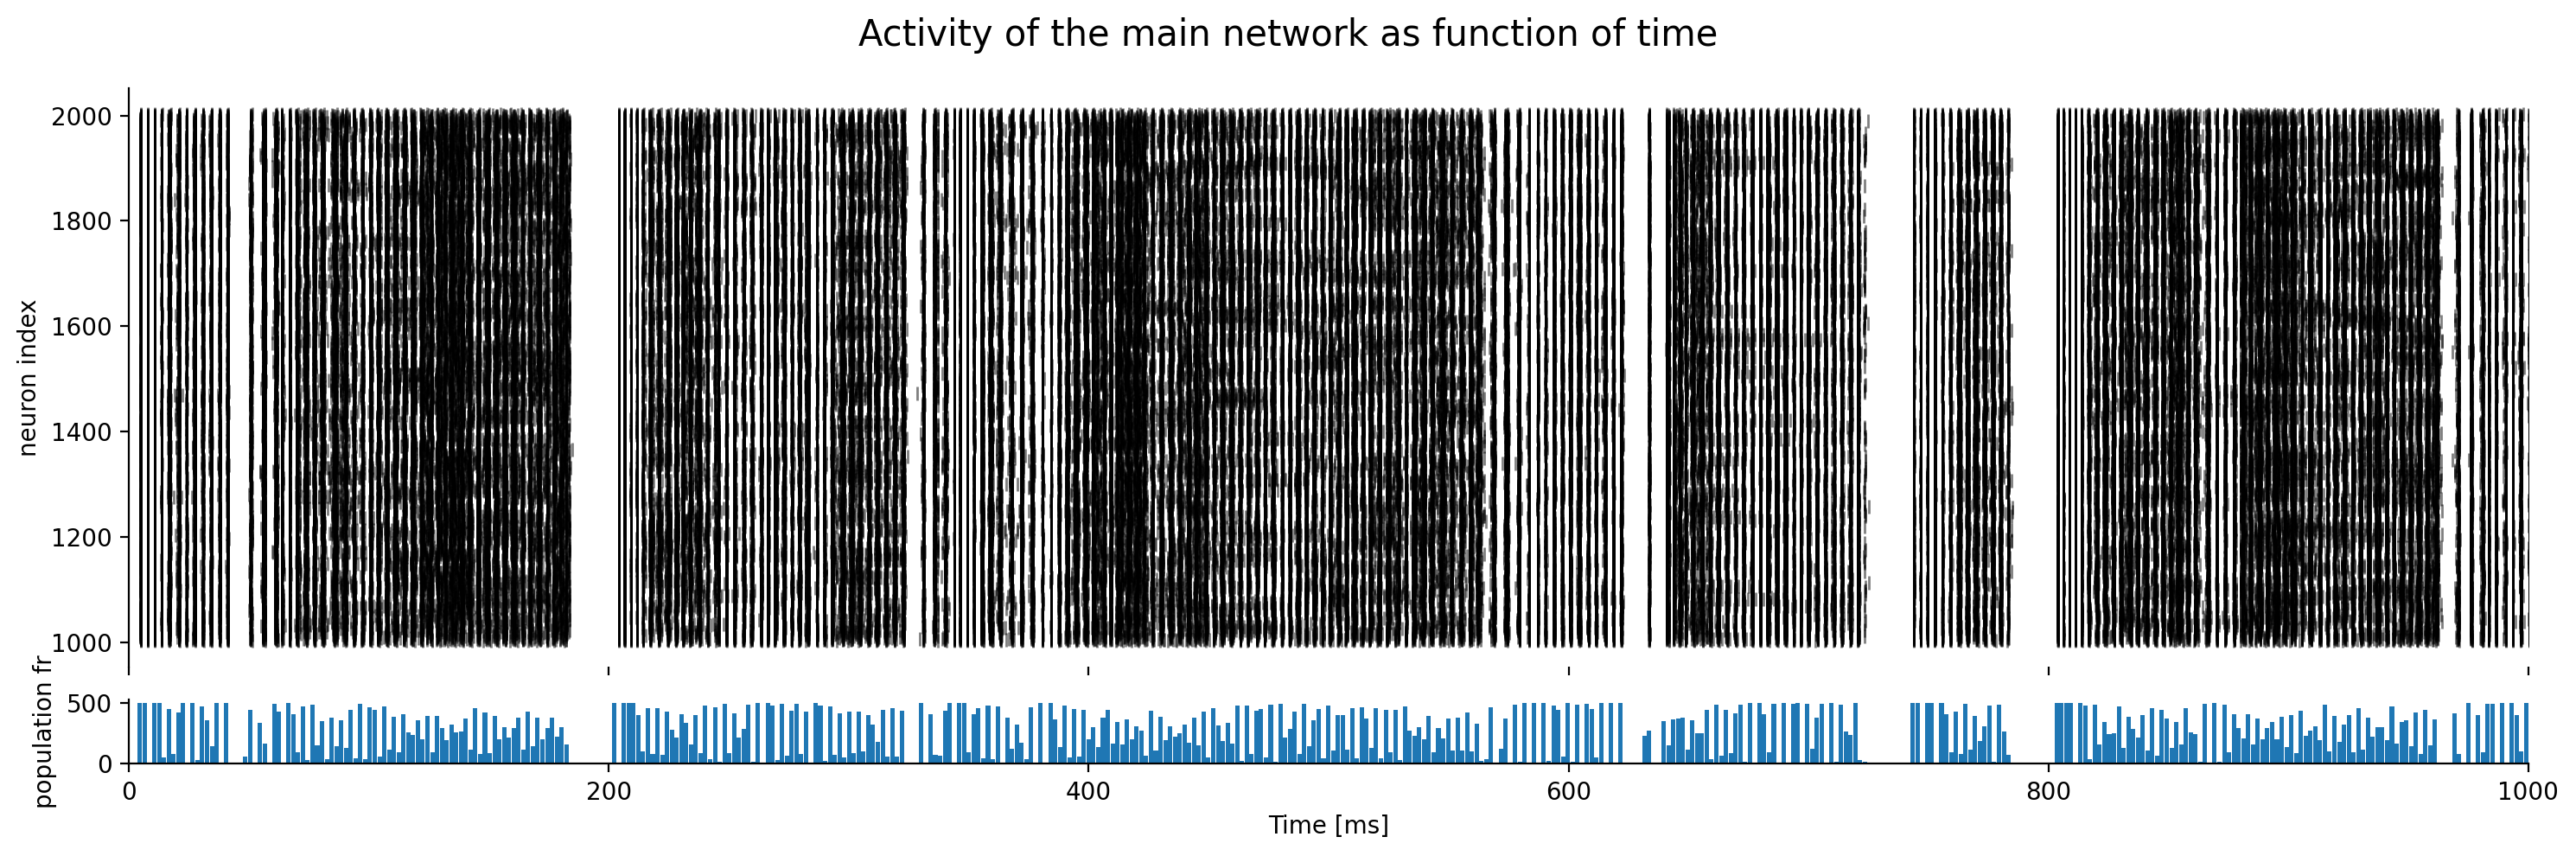

In [212]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    main_spks.events["times"],
    main_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    main_spks.events["times"],
    bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 1_000)
ax[0].set_ylabel(r"neuron index")
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr")
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the main network as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

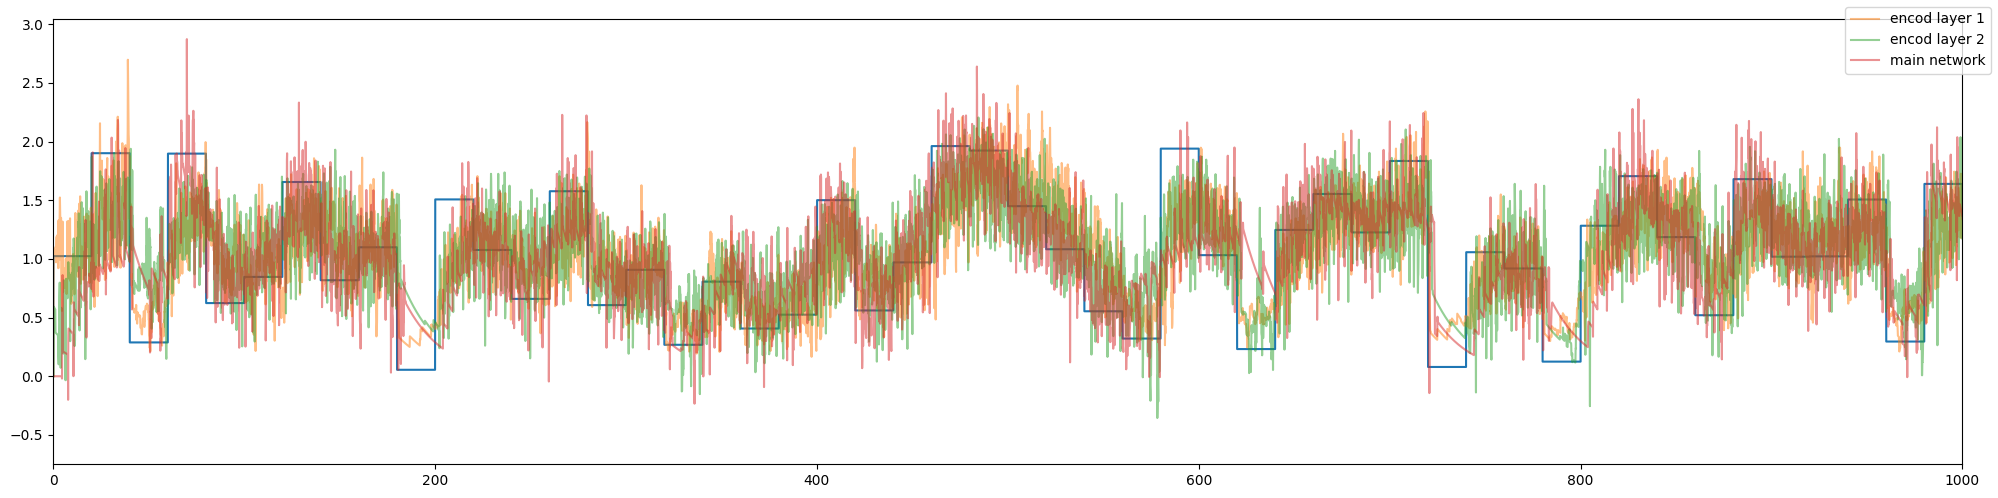

In [213]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    times,
    sig
)

ax.plot(
    times[1:],
    enc_estimate_1,
    alpha=0.5,
    label="encod layer 1"
)

ax.plot(
    times[1:],
    enc_estimate_2,
    alpha=0.5,
    label="encod layer 2"
)

ax.plot(
    times[1:],
    main_estimate,
    alpha=0.5,
    label="main network"
)

ax.set_xlim(0,1_000)
fig.legend()

plt.tight_layout()
plt.show()